In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from load import get_measures
from load import load_data
from load import train_test_split
from matplotlib import rcParams
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import json
import numpy as np
import warnings # retirar avisos
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 25, 15
#plt.style.use('fivethirtyeight') # estilo dos gráficos

In [ ]:
with open('selected_vars.json') as f:
    my_dict = json.load(f)

In [31]:
l = []
cols = []
for file in os.listdir("validation"):
    if ("cv.json" in file):
        file_name = "validation/" + file
        with open(file_name) as f:
            my_dict = json.load(f)
        pred_ = pd.Series(my_dict["cv_1"]["pred"])
        l.append(pred_)
        cols.append(file[:-8])
test_path = "validation/" + os.listdir("validation")[0]
with open(test_path) as f:
    my_dict = json.load(f)
    test = pd.Series(my_dict["cv_1"]["test"], name="test")

In [32]:
forecasts = pd.concat(l, axis = 1)
forecasts.columns = cols
forecasts["ensemble"] = forecasts[["hw", "prophet"]].mean(axis = 1)
df_comp = pd.concat([forecasts, test], axis = 1)
df_comp

,hw,multivariate_lightgbm,prophet,ensemble,test
0,11919.438150,11742.294902,12193.868008,12056.653079,11964.909375
1,11946.066058,11752.398106,12251.303738,12098.684898,12269.051375
2,11784.821545,11673.182633,12209.196016,11997.008781,12021.415458
3,11382.056437,11756.246350,12090.437906,11736.247171,11802.526458
4,9779.047721,10086.618251,10849.517170,10314.282446,10256.970375
5,8538.660342,9414.412437,9604.316493,9071.488418,8938.579125
6,11460.624157,11647.149970,11817.471880,11639.048019,11713.104333
7,11829.457701,11914.721892,12143.945300,11986.701500,12054.195042
8,11856.085609,11408.059072,12206.025336,12031.055473,12186.721375
9,11694.841096,11993.182061,12169.502609,11932.171853,12482.523708


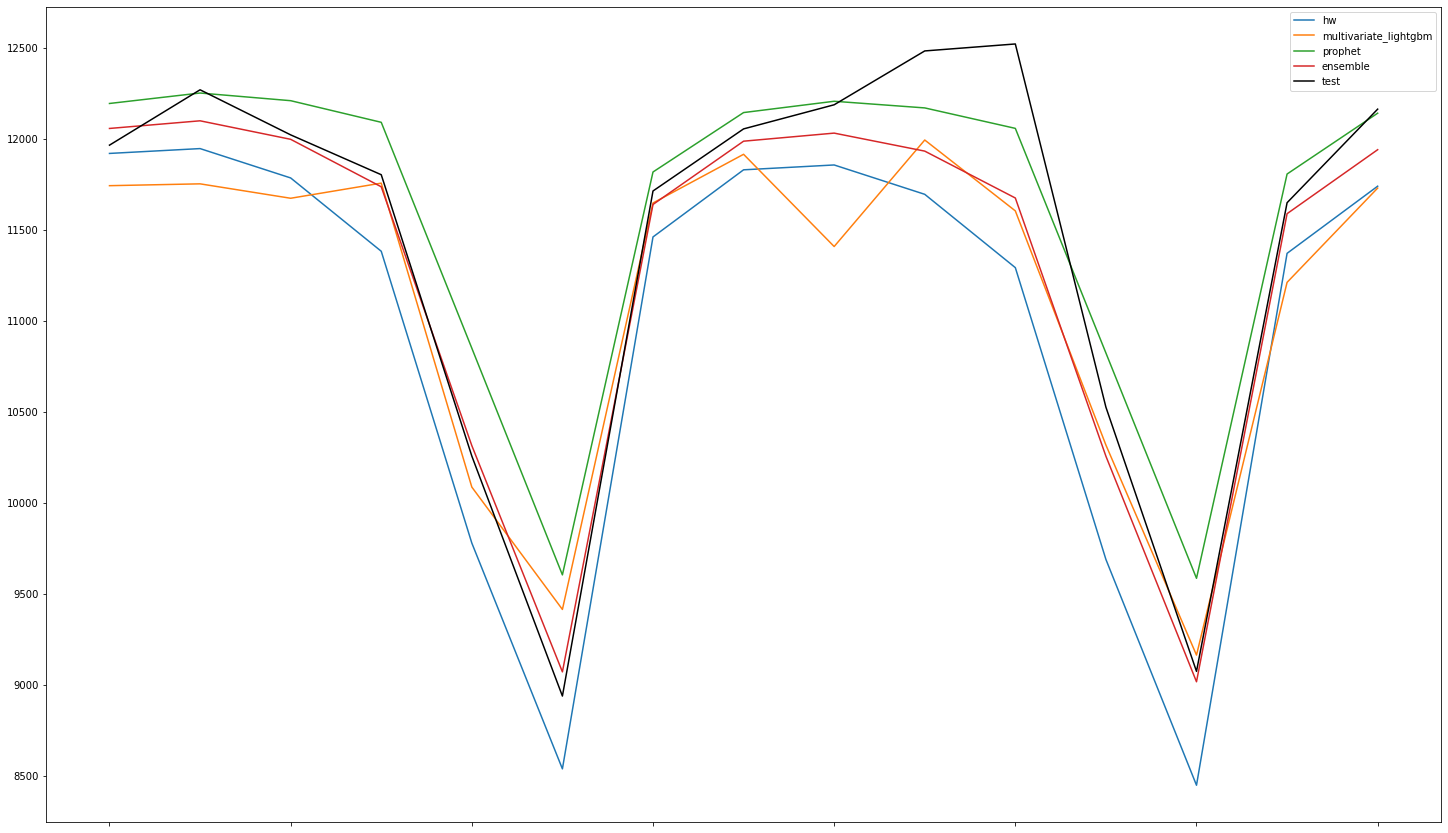

In [41]:
# plot forecasts
for model in df_comp.columns:
    if model == "test":
        continue
    plt.plot(df_comp[model], label = model)

# plot observed values
plt.plot(df_comp["test"], c = "black", label = "test")

# remove values from X axis
frame1 = plt.gca()  
frame1.axes.xaxis.set_ticklabels([])

# show legend on the right of the plot
plt.legend(bbox_to_anchor = (1,1)) 

plt.show()

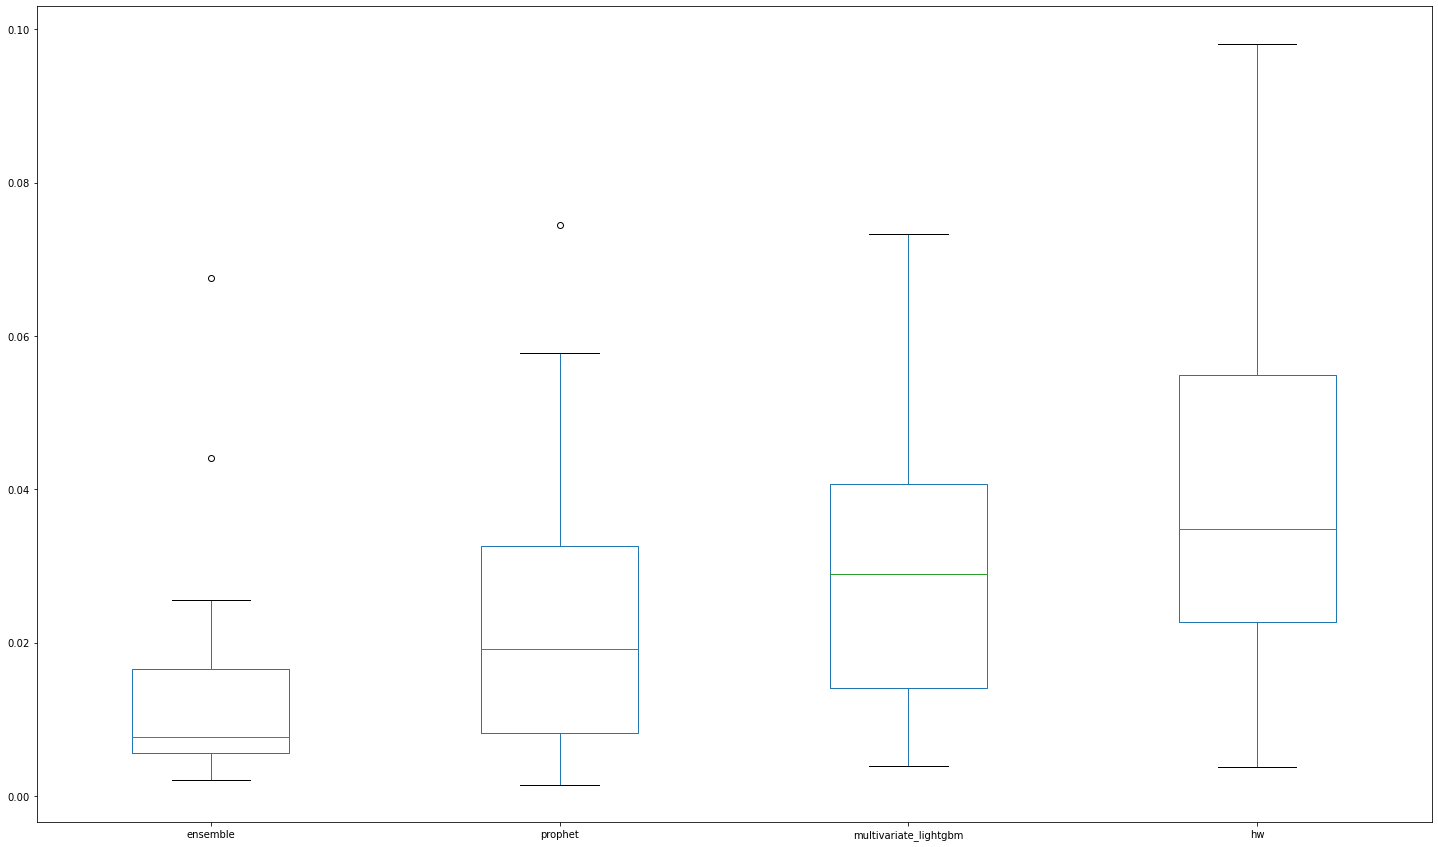

In [39]:
# df de erros por modelo
df_errors = df_comp.copy(deep=True)
for col in df_errors.columns:
    if col == 'test':
        continue
    else:
        #df_errors[col] = df_errors[col] - df_errors['test']
        df_errors[col] = abs(df_errors[col] - df_errors['test'])/df_errors['test']
df_errors.drop("test", axis = 1, inplace = True)

#sorted_index = df_errors.abs().sum().sort_values().index # ordernar boxplot seguinte por total de erros
sorted_index = df_errors.quantile(.9).sort_values().index # ordernar boxplot seguinte pelo quantil 95
df_sorted=df_errors[sorted_index].abs()

plt.figure()
df_sorted.iloc[:, :8].boxplot(grid = False)



plt.show()
#plt.savefig("distribuicao_erros_modelos_fc.jpeg")

### Medidas de acurácia

In [40]:
dict_metrics = []
for model in df_comp.columns:
    # skips test column
    if model == "test":
        continue
    # for every model's forecast column
    else:
        # create a dict containing the accuracy measures
        measures = get_measures(df_comp[model], df_comp["test"])
        # create a column with the model name
        measures["model"] = model
        # append dictionary to list
        dict_metrics.append(measures)
# create dataframe from list of dicionaries
df2_metrics = pd.DataFrame(dict_metrics)   
# set the last column (model name) as the first one for a better view
temp_cols = df2_metrics.columns.to_list()
new_col_order = temp_cols[-1:] + temp_cols[:-1]
df2_metrics = df2_metrics[new_col_order]

df2_metrics.sort_values(by = "mape")

# write excel file
#df2_metrics.to_excel("performance_df.xlsx", index = False)

,model,erro,mae,mse,rmse,mape,smape,r2
3,ensemble,1.245650e+06,189.7487,83043.3029,288.1723,0.0161,1.6358,0.9356
2,prophet,1.672882e+06,263.9752,111525.4510,333.9543,0.0249,2.4461,0.9136
1,multivariate_lightgbm,2.836398e+06,355.9275,189093.1761,434.8485,0.0307,3.1157,0.8534
0,hw,4.428673e+06,459.3951,295244.8813,543.3644,0.0408,4.2020,0.7712


In [25]:
#df2_metrics.to_excel("performance_df.xlsx", index = False)

# TODOS CVS

In [ ]:
l = []
cols = []
for file in os.listdir("validation"):
    if ("cv.json" in file):
        file_name = "validation/" + file
        with open(file_name) as f:
            my_dict = json.load(f)
        pred_ = pd.Series(my_dict["cv_1"]["pred"])
        l.append(pred_)
        cols.append(file[:-8])
test_path = "validation/" + os.listdir("validation")[0]
with open(test_path) as f:
    my_dict = json.load(f)
    test = pd.Series(my_dict["cv_1"]["test"], name="test")

In [45]:
l = []
for file in os.listdir("validation"):
    if ("cv.json" in file):
        file_name = "validation/" + file
        with open(file_name) as f:
            my_dict = json.load(f)
        #mapes = []
        for key, values in my_dict.items():
        #     mape_ = get_measures(pd.Series(my_dict[key]["pred"]), pd.Series(my_dict[key]["test"]))["mape"]
        #     mapes.append(mape_)
        # print(file, np.mean(mapes))~


hw_cv.json 0.09385333333333333
multivariate_lightgbm_cv.json 0.07481333333333334
prophet_cv.json 0.07393333333333334


In [48]:
with open("validation/hw_cv.json") as f:
    hw_f = json.load(f)
with open("validation/prophet_cv.json") as f:
    prophet_f = json.load(f)

In [52]:
hw_f.items()

dict_items([('cv_15', {'pred': [11287.853069418126, 11581.772442994949, 11401.424303274054, 11195.715295750007, 9491.90435634095, 8110.553309913205, 10839.174672923793, 11154.334856262472, 11448.254229839296, 11267.9060901184, 11062.197082594354, 9358.386143185297, 7977.035096757553, 10705.656459768139, 11020.816643106818], 'test': [11379.10191667, 11366.35033333, 11496.866375, 12086.04983333, 10735.20925, 8756.46366667, 11573.89458333, 12407.179875, 12829.40883333, 13124.67345833, 12997.84475, 11222.38875, 9698.73195833, 11705.406875, 10842.36954167]}), ('cv_14', {'pred': [11519.205011696455, 11390.243160551516, 11200.854499862035, 9456.649540809714, 7985.588954855521, 10675.595874398827, 11107.693855264377, 11352.609621981203, 11223.647770836265, 11034.259110146782, 9290.054151094464, 7818.993565140268, 10509.000484683576, 10941.098465549123, 11186.014232265952], 'test': [13257.61425, 13684.007625, 13879.06420833, 11842.47825, 9886.60795833, 12696.58891667, 13121.16454167, 13260.5997

In [61]:
for cv, values in hw_f.items():
    l_ = []
    hw_f_vals = hw_f[cv]["pred"]
    prophet_f_vals = prophet_f[cv]["pred"]
    l_.append(pd.Series(hw_f_vals))
    l_.append(pd.Series(prophet_f_vals))
    df_ensemble_cv = pd.concat(l_, axis=1, )
    ensemble = df_ensemble_cv.mean(axis=1)

0     11675.911037
1     11862.653745
2     11764.727448
3     11618.585667
4     10164.140697
5      8861.756526
6     11334.749498
7     11663.236201
8     11847.317008
9     11745.547465
10    11594.519620
11    10134.325696
12     8825.546472
13    11291.746128
14    11613.313201
dtype: float64
0     11891.783246
1     11809.732243
2     11661.706603
3     10176.575038
4      8819.345179
5     11264.792837
6     11644.312390
7     11799.796826
8     11721.542736
9     11579.334952
10    10102.026077
11     8754.544506
12    11211.523211
13    11604.151466
14    11774.058026
dtype: float64
0     13007.214844
1     12891.312327
2     11417.582910
3     10103.346806
4     12561.309641
5     13072.105797
6     13314.264049
7     13273.417217
8     13165.869241
9     11697.782357
10    10386.148820
11    12843.406902
12    13349.993409
13    13584.316931
14    13531.973334
dtype: float64
0     13259.028915
1     11781.431844
2     10470.116825
3     12931.004088
4     13353.681198
5    